# Homography estimation via the DLT

Your name: Dylan Rodrigues

Your ID number: 24121479

No we're going to read two images in, a left image and a right image. And we are going to estimate the homography between the two images, so that we can create an approsimate panorama. You know the panorama mode in your phone camera (or panorama app)? This is basically what that photo app does.

Let's start by reading the two images.

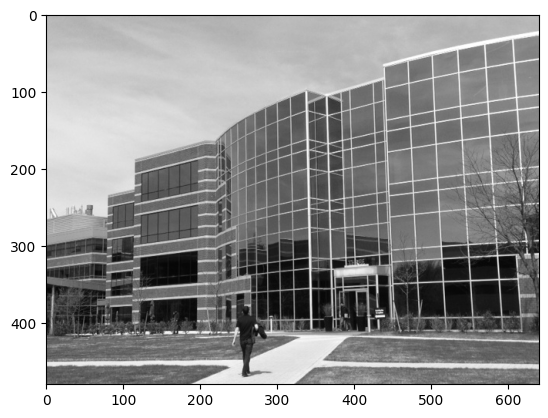

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL = cv2.imread('building1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgL,cmap='gray');

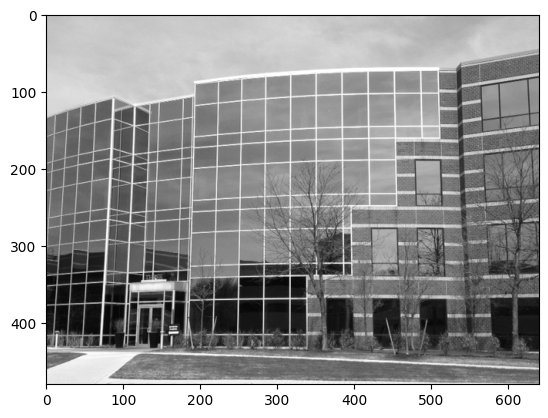

In [2]:
imgR = cv2.imread('building2.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgR,cmap='gray');

In previous vision modules, you will have covered feature matching. I don't expect you to repeat that here. So I will give you the code to match the two images using ORB. And we will match the features between the frames.

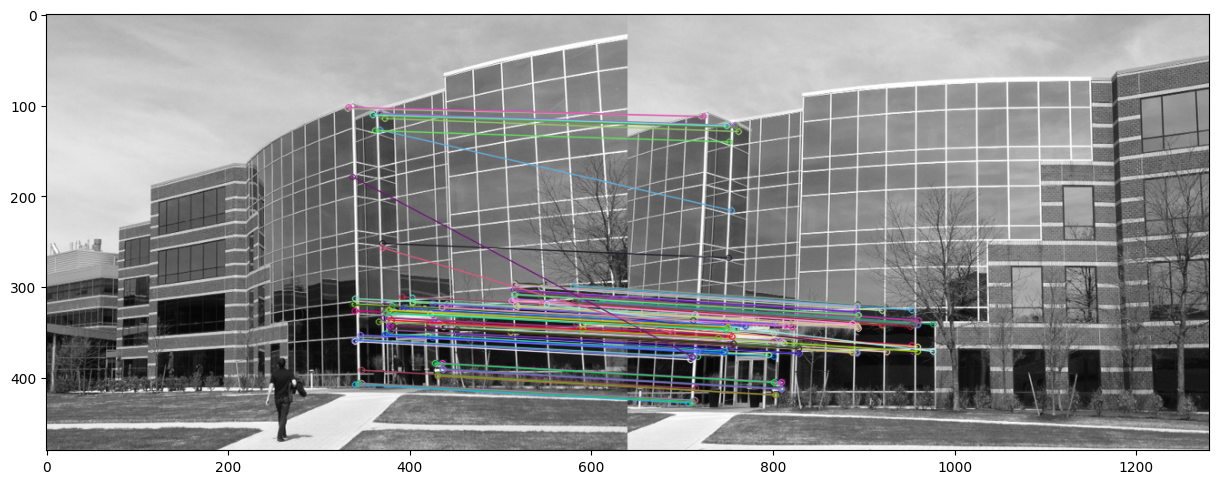

In [3]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(imgL,None)
kp2, des2 = orb.detectAndCompute(imgR,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:120],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

So we can now see the features in each image (circles) and thei corresponding matches (lines). What can we say about it? It seems that there are a lot of good matches, but a few outliers as well.

## Direct Linear Transform

We're going to estimate the homography between the two images using the direct linear transform, as discussed in Lecture 3.3.

Recall that we do this by building our $\textbf{B}$ matrix, and then applying the SVD.
![image.png](attachment:8c484abd-ca25-4b9b-85f8-42f2b1b722f5.png)

The full algorithm for estimating the homgraphy through the direct linear transform is given at the end of that lecture video:
![image.png](attachment:14e8e5ad-0ca2-4b61-af86-0148b7cceed6.png)

However, we know that the DLT is very susceptible to noise. So, for the moment, let's take the first 40 ORB matches, for now, and build the direct linear transform. In OpenCV, the sift matcher sorts the list of mathes by "goodness" of match. So, if we take just the first 40, we can be pretty sure that we won't get any outliers. Let's have a look.

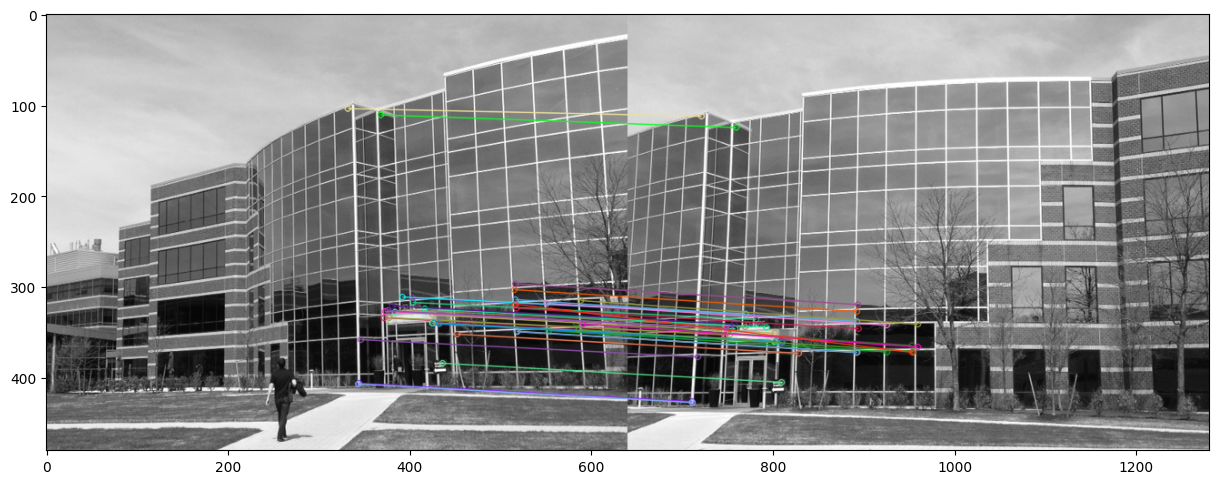

In [4]:
# Draw first 40 matches.
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:40],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

Yep, these matches look very clean. Let's work with these for now. Later we will try adding sme feature that are outliers, to see what happens, but for now, go with these first forty features.

In [5]:
# Take the first forty features, which we are pretty happy are inliers.

# OpenCV is a little convoluted in how it manages the correspondences, so I
# simplified it. In this code, I have reformatted the correspondence list
# such that the left and right points at at corresponding locations in the
# lists.

# that is,
#      left_pts[0] <-> rght_pts[0]
#      left_pts[1] <-> rght_pts[1]
#         and so on

left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:40]]).reshape(-1,2)
rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:40]]).reshape(-1,2)

<font color='blue'>
    
#### Task

Using the forty good features above, estimate the homography matrix using the DLT algorithm above.
    
Warp the right image according to the homography. I don't expect you to implement this yourself (though, if you did want to, it wouldn't be dissimilar to what you did in the last activity). Instead, I suggest we use the OpenCV [`cv2.warpPerspective`](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) function to do this.
    
Notes:
 * To build the $\mathbf{B}$ matrix, you might consider building the 2x9 sub-matrix $\mathbf{B}_i$ for each correspondence pair, and then stack the matrices ([`np.append`](https://numpy.org/doc/stable/reference/generated/numpy.append.html) setting `axis=0`)
 * In the lecture, I mention the command to run the [SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).
 * Use the [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) command to convert the 9-vector to the 3x3-matrix
 * The homography estimation gives us the transform that maps points in the left image to points in the right image. However, we want to match the right image to the left image, so we should use the *inverse* of the homography.
 * `cv2.warpPerspective` takes three arguments: 1) the image to warp, 2) the matrix to use to do the warping, and 3) the size of the output image. For the size of the image, I suggest to set it to `(1000,imgL.shape[0])`. This is big enough to accomodate the generated panorama.

In [6]:
len(left_pts)

40

In [7]:
len(rght_pts)

40

In [9]:
left_pts_39 = left_pts[:39]
len(left_pts_39)

39

In [11]:
rght_pts_39 = rght_pts[:39]
len(rght_pts_39)

39

(78, 9)
[[-3.89055212e-03  2.69161896e-04  9.82111471e-01]
 [-6.22867827e-04 -3.58278295e-03  1.88201064e-01]
 [-1.45756410e-06  7.01240318e-08 -2.99749573e-03]]


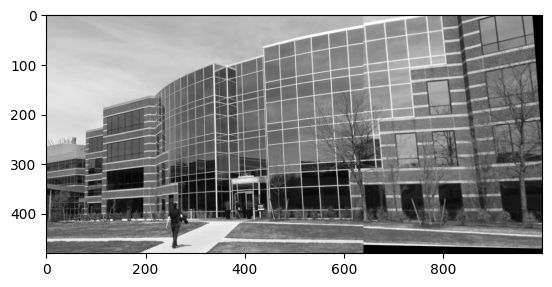

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Helper function to compute the B matrix from correspondences
def compute_B_matrix(left_pts, right_pts):
    B = np.empty((0, 9))  # Initialize an empty array for stacking B matrices
    for i in range(len(left_pts)):
        xL, yL = left_pts[i]
        xR, yR = right_pts[i]

        # Create the 2x9 sub-matrix Bi for each correspondence pair
        Bi = np.array([
            [-xL, -yL, -1, 0, 0, 0, xR * xL, xR * yL, xR],
            [0, 0, 0, -xL, -yL, -1, yR * xL, yR * yL, yR]
        ])

        # Append the Bi matrix to the B matrix
        B = np.append(B, Bi, axis=0)
    print(B.shape)
    return B

# Helper function to compute homography using SVD
def compute_homography(B_matrix):
    # Perform SVD on the B matrix
    _, _, VT = np.linalg.svd(B_matrix, full_matrices=True)

    # The last column of VT is the solution to the homography
    h = VT[-1]

    # Reshaping it to a 3x3 matrix
    homography = h.reshape(3, 3)
    print(homography)
    return homography

# Helper function to warp the right image using the homography
def warp_image(imgR, homography, output_size):
    return cv2.warpPerspective(imgR, homography, output_size)

# Estimate the homography using the DLT method (SVD based)
# Compute the B matrix from the left and right points
B_matrix = compute_B_matrix(left_pts_39, rght_pts_39)

# Compute the homography using SVD
H = compute_homography(B_matrix)

# Compute the inverse homography since we want to map the right image to the left image
H_inv = np.linalg.inv(H)

# Warp the right image using the inverse homography
imgW = warp_image(imgR, H_inv, (1000, imgL.shape[0]))  # Use the output size (1000, imgL.shape[0])

# Place the left image into the output image at the requisite position
imgW[:,:imgL.shape[1]] = imgL

# Display the result
plt.imshow(imgW, cmap='gray')

## Impact of outliers

Now let's see what happens when we add in some outliers. We'll take 80 of our features above. We start seeing some outliers creep in. What impact do these have on the DLT algorithm?

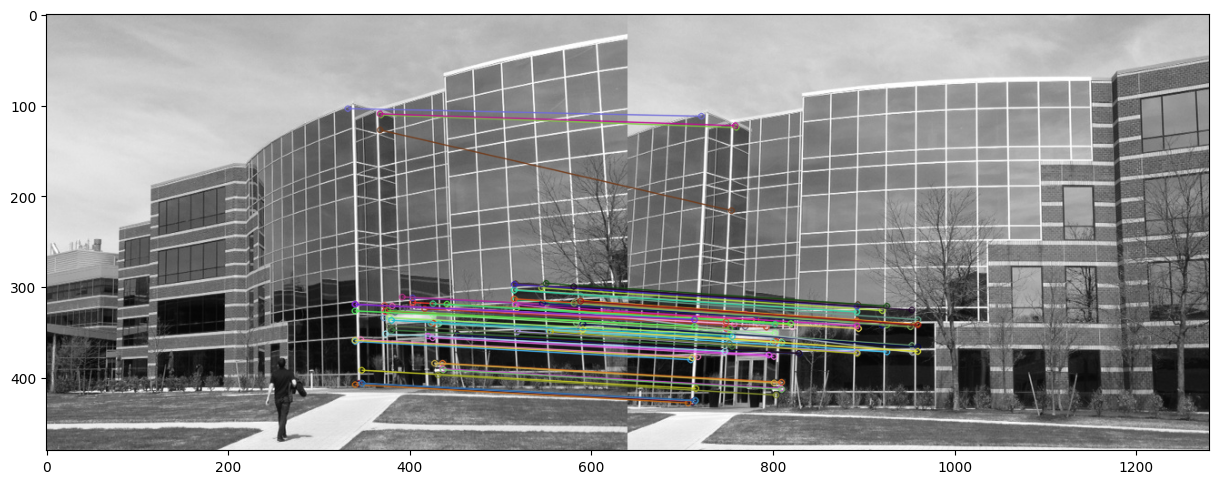

In [13]:
# Draw first 80 matches.
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:80],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

# Take the first 80 features, which we are pretty happy are inliers.
left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:80]]).reshape(-1,2)
rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:80]]).reshape(-1,2)

<font color='blue'>

#### Task

The variables `left_pts` and `rght_pts` now contain 80 feature correspondences, which includes some outliers. Rerun (i.e., feel free to copy-paste the code from above) the DLT-based homography estimation that you wrote above, but using these 80 features.

(160, 9)
[[ 2.49021602e-03  9.40783793e-05 -8.19356416e-01]
 [ 1.37455072e-03  1.64359295e-03 -5.73274756e-01]
 [ 3.90290997e-06  1.40803671e-06 -5.62243516e-04]]


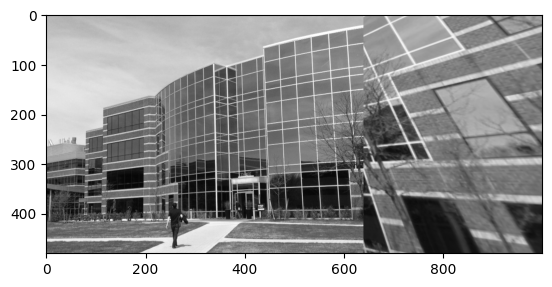

In [14]:
##################
# Your code here
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Helper function to compute the B matrix from correspondences
def compute_B_matrix(left_pts, right_pts):
    B = np.empty((0, 9))  # Initialize an empty array for stacking B matrices
    for i in range(len(left_pts)):
        xL, yL = left_pts[i]
        xR, yR = right_pts[i]

        # Create the 2x9 sub-matrix Bi for each correspondence pair
        Bi = np.array([
            [-xL, -yL, -1, 0, 0, 0, xR * xL, xR * yL, xR],
            [0, 0, 0, -xL, -yL, -1, yR * xL, yR * yL, yR]
        ])

        # Append the Bi matrix to the B matrix
        B = np.append(B, Bi, axis=0)
    print(B.shape)
    return B

# Helper function to compute homography using SVD
def compute_homography(B_matrix):
    # Perform SVD on the B matrix
    _, _, VT = np.linalg.svd(B_matrix, full_matrices=True)

    # The last column of VT is the solution to the homography
    h = VT[-1]

    # Reshape it to a 3x3 matrix
    homography = h.reshape(3, 3)
    print(homography)
    return homography

# Helper function to warp the right image using the homography
def warp_image(imgR, homography, output_size):
    return cv2.warpPerspective(imgR, homography, output_size)

# Estimate the homography using the DLT method (SVD based)
# Compute the B matrix from the left and right points
B_matrix = compute_B_matrix(left_pts, rght_pts)

# Compute the homography using SVD
H = compute_homography(B_matrix)

# Compute the inverse homography since we want to map the right image to the left image
H_inv = np.linalg.inv(H)

# Warp the right image using the inverse homography
imgW = warp_image(imgR, H_inv, (1000, imgL.shape[0]))  # Use the output size (1000, imgL.shape[0])

# Place the left image into the output image at the requisite position
imgW[:,:imgL.shape[1]] = imgL

# Display the result
plt.imshow(imgW, cmap='gray')

<font color='blue'>
    
##### Question: describe the impact of just the modest number of outlier?

!Your answer here!

A modest number of outliers can significantly degrade the accuracy of homography estimation using the Direct Linear Transform (DLT) algorithm. Since DLT is a least-squares-based method, it is highly sensitive to noise and outliers, which can lead to an incorrect homography matrix. This results in distortions, misalignments, and ghosting effects in the warped image, as erroneous correspondences bias the transformation. Robust estimation methods, such as RANSAC, are typically employed to mitigate the impact of outliers by iteratively selecting inlier subsets to compute a more reliable homography (Hartley & Zisserman, Multiple View Geometry in Computer Vision, 2004).